#### By: Peyman Shahidi
#### Created: Oct 29, 2025
#### Last Edit: Nov 3, 2025

<br>

In [1]:
#Python
import getpass
import numpy as np
import pandas as pd
from collections import defaultdict
import itertools
import random 

## formatting number to appear comma separated and with two digits after decimal: e.g, 1000 shown as 1,000.00
pd.set_option('float_format', "{:,.2f}".format)

import matplotlib.pyplot as plt
#%matplotlib inline
#from matplotlib.legend import Legend

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200)

In [2]:
#Python
import getpass
import numpy as np
import pandas as pd
from collections import defaultdict
import itertools
import random 

## formatting number to appear comma separated and with two digits after decimal: e.g, 1000 shown as 1,000.00
pd.set_option('float_format', "{:,.2f}".format)

import matplotlib.pyplot as plt
#%matplotlib inline
#from matplotlib.legend import Legend

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200)

main_folder_path = ".."
input_data_path = f"{main_folder_path}/data"
# Modify the output path accordingly
output_data_path = f'{input_data_path}/computed_objects/BLS_ONET_matchedEmpShares'
output_plot_path = f"{main_folder_path}/writeup/plots/anthropic_AI_index/BLS_ONET_matchedEmpShares"
output_plot_path_by_BLS_sector = f"{main_folder_path}/writeup/plots/anthropic_AI_index/BLS_ONET_matchedEmpShares/by_BLS_sector"
output_plot_path_by_ONET_level = f"{main_folder_path}/writeup/plots/anthropic_AI_index/BLS_ONET_matchedEmpShares/by_ONET_level"
output_plot_path_by_weighting_scheme = f"{main_folder_path}/writeup/plots/anthropic_AI_index/BLS_ONET_matchedEmpShares/by_weighting_scheme"
output_plot_path_by_dependent_var = f"{main_folder_path}/writeup/plots/anthropic_AI_index/BLS_ONET_matchedEmpShares/by_dependent_var"

# Toggle: if True, randomly reassign occ_totalEmpShare weights in the merged master_df
# during the merge_industry_employment_shares step. Set to False for default behavior.
randomize_occ_weights = True


In [3]:
import os
for path in [output_data_path, output_plot_path, 
             output_plot_path_by_BLS_sector, output_plot_path_by_ONET_level, 
             output_plot_path_by_weighting_scheme, output_plot_path_by_dependent_var]:
    if not os.path.exists(path):
        os.makedirs(path)

## Functions

In [4]:
def create_occupation_analysis(df, onet_occupation_code_var, onet_occupation_title_var):
    # Create occupation-level analysis for scatter plots
    # Group by occupation and calculate label fractions and task counts
    occupation_stats = []

    for (soc_code, occ_title), group in df.groupby([onet_occupation_code_var, onet_occupation_title_var]):
        num_tasks = group['Task ID'].nunique()
        # num_occupations = group[onet_occupation_code_var].nunique()
        total_tasks = len(group)
        
        manual_fraction = (group['label'] == 'Manual').sum() / total_tasks
        augmentation_fraction = (group['label'] == 'Augmentation').sum() / total_tasks  
        automation_fraction = (group['label'] == 'Automation').sum() / total_tasks
        ai_fraction = augmentation_fraction + automation_fraction
        gpt4_E0_fraction = (group['gpt4_exposure'] == 'E0').sum() / total_tasks
        gpt4_E1_fraction = (group['gpt4_exposure'] == 'E1').sum() / total_tasks
        gpt4_E2_fraction = (group['gpt4_exposure'] == 'E2').sum() / total_tasks
        gpt4_aiExposure_fraction = gpt4_E1_fraction + gpt4_E2_fraction
        human_E0_fraction = (group['human_labels'] == 'E0').sum() / total_tasks
        human_E1_fraction = (group['human_labels'] == 'E1').sum() / total_tasks
        human_E2_fraction = (group['human_labels'] == 'E2').sum() / total_tasks
        human_aiExposure_fraction = human_E1_fraction + human_E2_fraction

        
        occupation_stats.append({
            f'{onet_occupation_code_var}': soc_code,
            f'{onet_occupation_title_var}': occ_title,
            'num_tasks': num_tasks,
            # 'num_occupations': num_occupations,
            'manual_fraction': manual_fraction,
            'ai_fraction': ai_fraction,
            'augmentation_fraction': augmentation_fraction,
            'automation_fraction': automation_fraction,
            'gpt4_E0_fraction': gpt4_E0_fraction,
            'gpt4_E1_fraction': gpt4_E1_fraction,
            'gpt4_E2_fraction': gpt4_E2_fraction,
            'gpt4_aiExposure_fraction': gpt4_aiExposure_fraction,
            'human_E0_fraction': human_E0_fraction,
            'human_E1_fraction': human_E1_fraction,
            'human_E2_fraction': human_E2_fraction,
            'human_aiExposure_fraction': human_aiExposure_fraction
        })

    occupation_analysis = pd.DataFrame(occupation_stats)

    return occupation_analysis



def merge_industry_employment_shares_master(my_sector, my_onet_level,
                                            onet_occupation_code_var,
                                            weight_cols,
                                            occupation_analysis,
                                            save=True,
                                            bls_file_path=None):


    # Merge industry employment share weights for all NAICS sectors and create a master dataset
    if not bls_file_path:
        bls_sector_shares = pd.read_csv(f'{input_data_path}/computed_objects/BLS_ONET_empShares/BLS{my_sector}_ONET{my_onet_level}_empShares.csv')
    else:
        bls_sector_shares = pd.read_csv(bls_file_path)

    # Ensure NAICS is string for consistent merging
    bls_sector_shares['NAICS'] = bls_sector_shares['NAICS'].astype(str)

    # Start with occupation_analysis as output_df
    output_df = occupation_analysis.copy()

    # For each weighting scheme, compute the weights and merge into output_df
    # 1) occ_totalEmpShare
    if 'occ_totalEmpShare' in weight_cols:
        bls_occ_totalEmpShares = bls_sector_shares[['OCC_CODE', 'TOT_EMP']].groupby('OCC_CODE').sum().reset_index()

        # Convert to % and change variable name
        bls_occ_totalEmpShares['TOT_EMP'] = bls_occ_totalEmpShares['TOT_EMP'] / bls_occ_totalEmpShares['TOT_EMP'].sum()
        bls_occ_totalEmpShares = bls_occ_totalEmpShares.rename(columns={'TOT_EMP': 'occ_totalEmpShare'})

        # Add weight column to output_df
        output_df = output_df.merge(bls_occ_totalEmpShares, left_on=onet_occupation_code_var, right_on=['OCC_CODE'], how='left')

    # 2) sectorEmpShare
    if 'sectorEmpShare' in weight_cols:
        sector_weights_df = bls_sector_shares[['NAICS', 'NAICS_TITLE', 'TOT_EMP']].groupby(['NAICS', 'NAICS_TITLE']).sum('TOT_EMP')

        # Convert to % and change variable name
        sector_weights_df['TOT_EMP'] = sector_weights_df['TOT_EMP'] / sector_weights_df['TOT_EMP'].sum()
        sector_weights_df = sector_weights_df.rename(columns={'TOT_EMP': 'sectorEmpShare'})

        # Merge back sector weights to bls dataset to get sector-by-sector occupation data with sector weights
        bls_sector_weights_df = bls_sector_shares[['NAICS', 'NAICS_TITLE', 'OCC_CODE', 'OCC_TITLE']].merge(sector_weights_df, on='NAICS', how='left')

        
        # Aggregate sector weights across occupations
        bls_sector_weights_occupation_df = bls_sector_weights_df.groupby('OCC_CODE').sum('sectorEmpShare')

        # Add weight column to output_df
        output_df = output_df.merge(bls_sector_weights_occupation_df, left_on=onet_occupation_code_var, right_on=['OCC_CODE'], how='left')

    # 3) occ_sectorEmpShare
    if 'occ_sectorEmpShare' in weight_cols:
        within_sector_weights_df = bls_sector_shares[['NAICS', 'NAICS_TITLE', 'OCC_CODE', 'OCC_TITLE', 'TOT_EMP']].copy()
        within_sector_weights_df['occ_sectorEmpShare'] = within_sector_weights_df['TOT_EMP'] / within_sector_weights_df.groupby(['NAICS', 'NAICS_TITLE'])['TOT_EMP'].transform('sum')

        # Calculate sum over all sectors
        within_sector_weights = within_sector_weights_df[['OCC_CODE', 'OCC_TITLE', 'occ_sectorEmpShare']].groupby(['OCC_CODE', 'OCC_TITLE']).sum()

        # Add weight column to output_df
        output_df = output_df.merge(within_sector_weights, left_on=onet_occupation_code_var, right_on=['OCC_CODE'], how='left')

    # Drop the 'OCC_CODE' column
    output_df = output_df.drop(columns='OCC_CODE')

    # Save master dataframe to CSV
    if save:
        output_df.to_csv(f'{output_data_path}/BLS{my_sector}_ONET{my_onet_level}.csv', index=False)

    return output_df



import statsmodels.formula.api as smf
def run_weighted_regression(my_sector, my_onet_level,
                           master_df, 
                           dependent_vars,
                           weight_cols,
                           out_file=None):

    results = []

    for weight_col in weight_cols:
        for dependent_var in dependent_vars:
            # Data prep
            df = master_df[[dependent_var, 'num_tasks', weight_col]].copy()
            df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=[dependent_var, 'num_tasks', weight_col])

            # Coerce numeric
            df['num_tasks'] = pd.to_numeric(df['num_tasks'], errors='coerce')
            df[dependent_var] = pd.to_numeric(df[dependent_var], errors='coerce')
            df[weight_col] = pd.to_numeric(df[weight_col], errors='coerce')

            if df.empty:
                continue

            # Regression
            model_wls = smf.wls(f'{dependent_var} ~ num_tasks', data=df, weights=df[weight_col]).fit(cov_type='HC3')

            # Store results
            results.append({
                'BLS_sector_level': my_sector,
                'ONET_level': my_onet_level,
                'dependent_var': dependent_var,
                'weight_col': weight_col,
                'model': 'WLS',
                'coef_num_tasks': float(model_wls.params.get('num_tasks', np.nan)),
                'std_err': float(model_wls.bse.get('num_tasks', np.nan)),
                'pvalue': float(model_wls.pvalues.get('num_tasks', np.nan)),
                'n_obs': int(model_wls.nobs)
            })

    reg_df = pd.DataFrame(results)

    if not out_file:
        reg_out_dir = f"{output_data_path}/regressions"
        os.makedirs(reg_out_dir, exist_ok=True)
        out_file = f"{reg_out_dir}/reg_BLS{my_sector}_ONET{my_onet_level}_on_numTasks.csv"
        reg_df.to_csv(out_file, index=False)
    else:
        reg_df.to_csv(out_file, index=False)



def regress_exposure_on_AIability(my_sector, my_onet_level,
                                  master_df,
                                  weight_cols,
                                  dependent_var='ai_fraction',
                                  regressor='human_E1_fraction',
                                  out_file=None):
    """
    For each weight column, run WLS: ai_fraction ~ human_E1_fraction + num_tasks,
    collect the coefficient on human_E1_fraction, and save all results in one CSV.
    Returns the results DataFrame.
    """

    results = []

    for weight_col in weight_cols:
        # Clean sample for this regression
        df = master_df[[dependent_var, regressor, 'num_tasks', weight_col]].copy()
        df = df.replace([np.inf, -np.inf], np.nan)
        df = df.dropna(subset=[dependent_var, regressor, 'num_tasks', weight_col])

        model = smf.wls(
            f'{dependent_var} ~ {regressor} + num_tasks',
            data=df,
            weights=df[weight_col]
        ).fit(cov_type='HC3')

        results.append({
            'BLS_sector_level': my_sector,
            'ONET_level': my_onet_level,
            'dependent_var': dependent_var,
            'weight_col': weight_col,
            'model': 'WLS_AIability_on_exposure',
            'coef_human_E1_fraction': float(model.params.get(regressor, np.nan)),
            'std_err': float(model.bse.get(regressor, np.nan)),
            'pvalue': float(model.pvalues.get(regressor, np.nan)),
            'n_obs': int(model.nobs),
        })

    res_df = pd.DataFrame(results)

    # Save one CSV with all weight cols
    if not out_file:
        reg_out_dir = f"{output_data_path}/regressions"
        os.makedirs(reg_out_dir, exist_ok=True)
        out_file = f"{reg_out_dir}/reg_BLS{my_sector}_ONET{my_onet_level}_AIability_on_exposure.csv"
        res_df.to_csv(out_file, index=False)
    else:
        res_df.to_csv(out_file, index=False)

#### Main Code

In [5]:
# Read the merged data
merged_data = pd.read_csv(f"{input_data_path}/computed_objects/ONET_Eloundou_Anthropic_GPT/ONET_Eloundou_Anthropic_GPT.csv")

In [6]:
# # Drop the supplemental tasks
# merged_data = merged_data[merged_data['Task Type'] != 'Supplemental'].reset_index(drop=True)

# # Drop rows whose Occupation Title includes 'Teachers, Postsecondary'
# merged_data = merged_data[~merged_data['Occupation Title'].str.contains('Teachers, Postsecondary')].reset_index(drop=True)

In [7]:
# Define levels and variables
bls_sector_levels = ['sector']#, '3-digit', '4-digit', '5-digit', '6-digit']

onet_levels = ['major', 'minor', 'broad', 'detailed']
onet_occupation_code_vars = ['Major_Group_Code', 'Minor_Group_Code', 'Broad_Occupation_Code', 'Detailed_Occupation_Code']
onet_occupation_title_vars = ['Major_Group_Title', 'Minor_Group_Title', 'Broad_Occupation_Title', 'Detailed_Occupation_Title']

weight_cols = ['occ_totalEmpShare',         # Weight each occupation by occupation's share of total employment (ignoring sector shares)
               'sectorEmpShare',            # Weight each occupation by its sector's share of total employment
               'occ_sectorEmpShare']        # Weight each occupation by its share of employment within its sector and weight sectors equally  

dependent_var_list = ['ai_fraction', 'human_E1_fraction']#, 'human_aiExposure_fraction']#, 'gpt4_E1_fraction']

In [8]:
# Run the analysis for each BLS sector level and ONET occupation level
# for my_sector in bls_sector_levels:
#     for my_onet_level, onet_occupation_code_var, onet_occupation_title_var in zip(onet_levels, onet_occupation_code_vars, onet_occupation_title_vars):
#         if my_onet_level != 'detailed':
#                     continue
        
my_sector = 'sector'
my_onet_level = 'detailed'
onet_occupation_code_var = 'Detailed_Occupation_Code'
onet_occupation_title_var = 'Detailed_Occupation_Title'

# Get occupation data
occupation_analysis = create_occupation_analysis(merged_data, onet_occupation_code_var, onet_occupation_title_var)

# Get master dataframe with all weighting schemes merged
master_df = merge_industry_employment_shares_master(my_sector, my_onet_level,
                                                    onet_occupation_code_var,
                                                    weight_cols,
                                                    occupation_analysis)

# Regress for different dependent vars and weighting schemes
run_weighted_regression(my_sector, my_onet_level,
                        master_df, 
                        dependent_var_list,
                        weight_cols)

# Regress exposure on AI ability
regress_exposure_on_AIability(my_sector, my_onet_level,
                            master_df,
                            weight_cols,
                            dependent_var='ai_fraction',
                            regressor='human_E1_fraction')

## Placebo Tests: 
#### 1 and 2) Reshuffle Task-Occupation Assignment and Repeat the Same Analysis
#### 3) Reshuffle BLS Weights and Repeat the Same Analysis

In [9]:
# 1) Use the preserved count reshuffled datasets to run the same regression of AI ability on exposure
iterations = 1000

path_suffix = 'taskReshuffled_preserveCounts'
regression_output_dir = f"{output_data_path}/regressions_{path_suffix}"
os.makedirs(regression_output_dir, exist_ok=True)

for i in range(iterations):
    file_path = f"{regression_output_dir}/reg_BLS{my_sector}_ONET{my_onet_level}_on_numTasks_iter{i+1}.csv"
    if os.path.exists(file_path):
        continue  # Skip iteration if file already exists

    if i % 50 == 0:
        print(f"Iteration {i+1} of {iterations}")
        
    # Load reshuffled data
    merged_df_reshuffled = pd.read_csv(f"{input_data_path}/computed_objects/ONET_Eloundou_Anthropic_GPT/{path_suffix}/ONET_Eloundou_Anthropic_GPT_iter{i+1}.csv")
    
    # Get occupation data
    occupation_analysis = create_occupation_analysis(merged_df_reshuffled, onet_occupation_code_var, onet_occupation_title_var)

    # Get master dataframe with all weighting schemes merged
    master_df = merge_industry_employment_shares_master(my_sector, my_onet_level,
                                                        onet_occupation_code_var,
                                                        weight_cols,
                                                        occupation_analysis,
                                                        save=False)

    # Regress for different dependent vars and weighting schemes
    run_weighted_regression(my_sector, my_onet_level,
                            master_df, 
                            dependent_var_list,
                            weight_cols,
                            out_file = f"{regression_output_dir}/reg_BLS{my_sector}_ONET{my_onet_level}_on_numTasks_iter{i+1}.csv")

    # Regress exposure on AI ability
    regress_exposure_on_AIability(my_sector, my_onet_level,
                                master_df,
                                weight_cols,
                                dependent_var='ai_fraction',
                                regressor='human_E1_fraction',
                                out_file = f"{regression_output_dir}/reg_BLS{my_sector}_ONET{my_onet_level}_AIability_on_exposure_iter{i+1}.csv")

In [10]:
# 2) Use the changed counts reshuffled datasets to run the same regression of AI ability on exposure
iterations = 1000

path_suffix = 'taskReshuffled_changeCounts'
regression_output_dir = f"{output_data_path}/regressions_{path_suffix}"
os.makedirs(regression_output_dir, exist_ok=True)

for i in range(iterations):
    file_path = f"{regression_output_dir}/reg_BLS{my_sector}_ONET{my_onet_level}_on_numTasks_iter{i+1}.csv"
    if os.path.exists(file_path):
        continue  # Skip iteration if file already exists
    
    if i % 50 == 0:
        print(f"Iteration {i+1} of {iterations}")
        
    # Load reshuffled data
    merged_df_reshuffled = pd.read_csv(f"{input_data_path}/computed_objects/ONET_Eloundou_Anthropic_GPT/{path_suffix}/ONET_Eloundou_Anthropic_GPT_iter{i+1}.csv")

    # Get occupation data
    occupation_analysis = create_occupation_analysis(merged_df_reshuffled, onet_occupation_code_var, onet_occupation_title_var)
    
    # Get master dataframe with all weighting schemes merged
    master_df = merge_industry_employment_shares_master(my_sector, my_onet_level,
                                                        onet_occupation_code_var,
                                                        weight_cols,
                                                        occupation_analysis,
                                                        save=False)

    # Regress for different dependent vars and weighting schemes
    run_weighted_regression(my_sector, my_onet_level,
                            master_df, 
                            dependent_var_list,
                            weight_cols,
                            out_file = f"{regression_output_dir}/reg_BLS{my_sector}_ONET{my_onet_level}_on_numTasks_iter{i+1}.csv")

    # Regress exposure on AI ability
    regress_exposure_on_AIability(my_sector, my_onet_level,
                                master_df,
                                weight_cols,
                                dependent_var='ai_fraction',
                                regressor='human_E1_fraction',
                                out_file = f"{regression_output_dir}/reg_BLS{my_sector}_ONET{my_onet_level}_AIability_on_exposure_iter{i+1}.csv")

In [11]:
# 3) Use the original task assignment but reshuffled BLS weights to run the same regression of AI ability on exposure
iterations = 1000

path_suffix = 'reshuffledBLSweights'
regression_output_dir = f"{output_data_path}/regressions_{path_suffix}"
os.makedirs(regression_output_dir, exist_ok=True)

# Get occupation data
occupation_analysis = create_occupation_analysis(merged_data, onet_occupation_code_var, onet_occupation_title_var)

for i in range(iterations):
    file_path = f"{regression_output_dir}/reg_BLS{my_sector}_ONET{my_onet_level}_on_numTasks_iter{i+1}.csv"
    if os.path.exists(file_path):
        continue  # Skip iteration if file already exists
    
    if i % 50 == 0:
        print(f"Iteration {i+1} of {iterations}")

    # Get master dataframe with all weighting schemes merged
    master_df = merge_industry_employment_shares_master(my_sector, my_onet_level,
                                                        onet_occupation_code_var,
                                                        weight_cols,
                                                        occupation_analysis,
                                                        save=False,
                                                        bls_file_path=f"{input_data_path}/computed_objects/BLS_ONET_empShares/BLS{my_sector}_ONET{my_onet_level}_reshuffledWeights/BLS{my_sector}_ONET{my_onet_level}_empShares_iter{i+1}.csv")

    # Regress for different dependent vars and weighting schemes
    run_weighted_regression(my_sector, my_onet_level,
                            master_df, 
                            dependent_var_list,
                            weight_cols,
                            out_file = f"{regression_output_dir}/reg_BLS{my_sector}_ONET{my_onet_level}_on_numTasks_iter{i+1}.csv")

    # Regress exposure on AI ability
    regress_exposure_on_AIability(my_sector, my_onet_level,
                                master_df,
                                weight_cols,
                                dependent_var='ai_fraction',
                                regressor='human_E1_fraction',
                                out_file = f"{regression_output_dir}/reg_BLS{my_sector}_ONET{my_onet_level}_AIability_on_exposure_iter{i+1}.csv")

## Plot

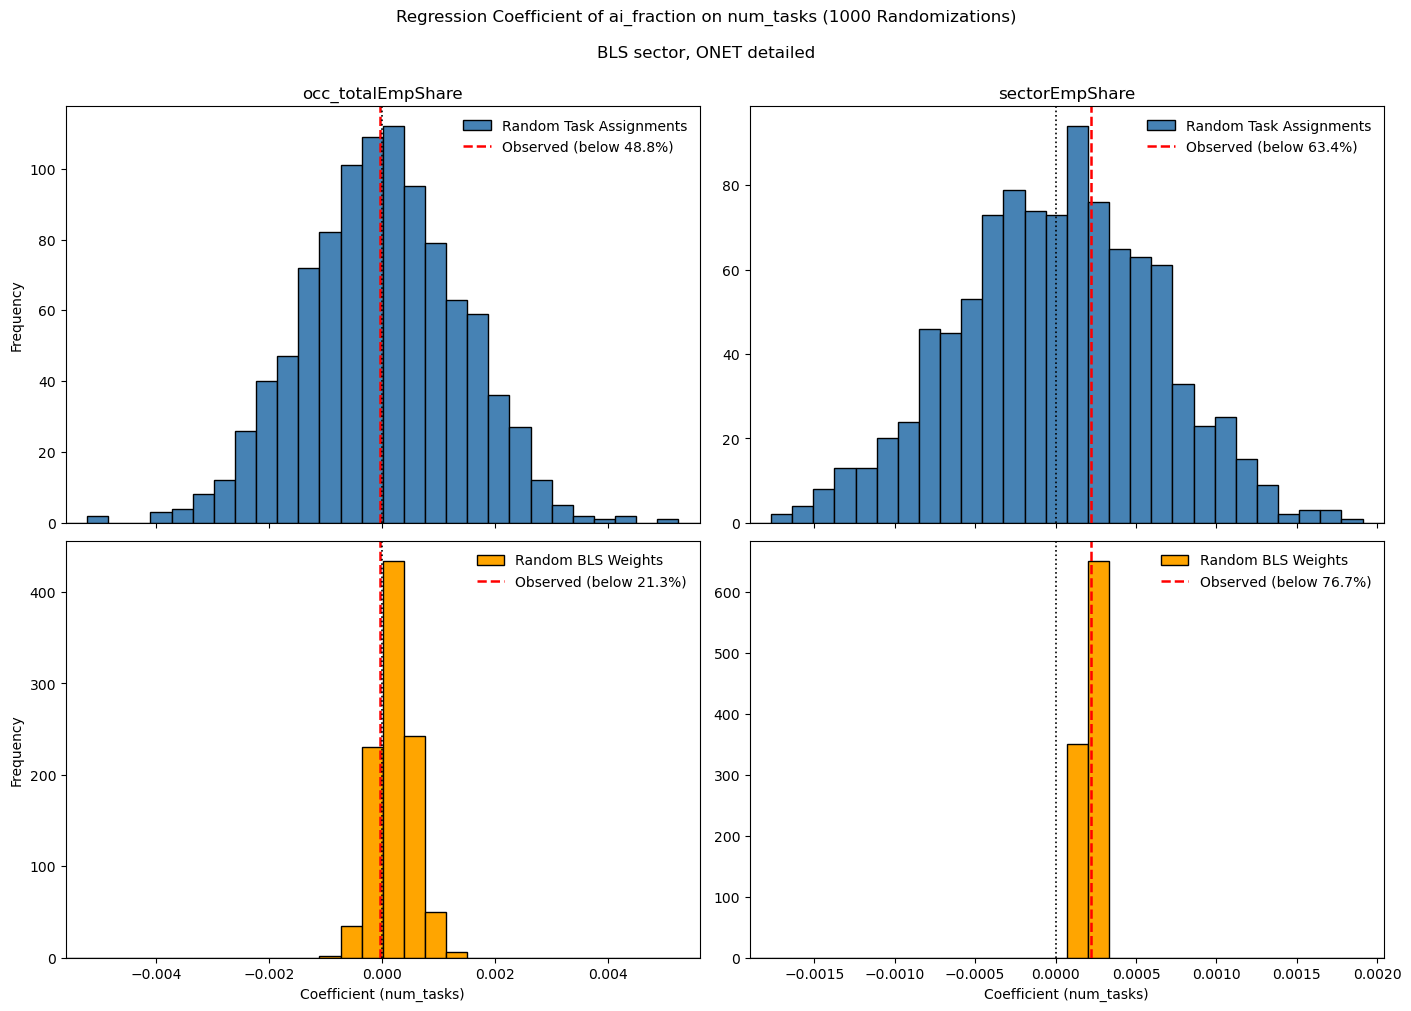

In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

dependent_var = 'ai_fraction'
observed_coef_df = pd.read_csv(
    f"{output_data_path}/regressions/reg_BLS{my_sector}_ONET{my_onet_level}_on_numTasks.csv"
)

reshuffles = [
    ('taskReshuffled_changeCounts', 'steelblue', 'Random Task Assignments'),
    ('reshuffledBLSweights', 'orange', 'Random BLS Weights')
]
weight_cols = ['occ_totalEmpShare', 'sectorEmpShare']  # now columns

# Preload all reshuffle results once
reshuffle_data = {}
for reshuffle_type, color, label in reshuffles:
    regression_output_dir = f"{output_data_path}/regressions_{reshuffle_type}"
    csv_files = [
        os.path.join(regression_output_dir, f)
        for f in os.listdir(regression_output_dir)
        if "on_numTasks" in f and f.endswith(".csv")
    ]
    if not csv_files:
        raise FileNotFoundError(f"No CSVs found in {regression_output_dir} with 'on_numTasks' in name.")
    reshuffle_data[reshuffle_type] = pd.concat(
        [pd.read_csv(p) for p in csv_files],
        ignore_index=True
    )

fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(14, 10),
    sharex='col',
    constrained_layout=True
)

# Precompute column-wise x-lims (shared across rows)
col_xlim = {}
observed_by_col = {}

for c, weight_col in enumerate(weight_cols):
    obs_mask = (observed_coef_df['weight_col'] == weight_col) & (observed_coef_df['dependent_var'] == dependent_var)
    if not obs_mask.any():
        raise ValueError(f"No observed coef for weight_col={weight_col}, dep={dependent_var} in observed_coef_df.")
    observed_coef = float(observed_coef_df.loc[obs_mask, 'coef_num_tasks'].iloc[0])
    observed_by_col[c] = observed_coef

    # Use both reshuffle types to define shared x-range
    series_list = []
    for reshuffle_type, _, _ in reshuffles:
        df_all = reshuffle_data[reshuffle_type]
        reg_df = df_all[(df_all['weight_col'] == weight_col) & (df_all['dependent_var'] == dependent_var)]
        series_list.append(reg_df['coef_num_tasks'].dropna().values)
    all_vals = np.concatenate(series_list) if series_list else np.array([0.0])
    xmin, xmax = np.nanmin(all_vals), np.nanmax(all_vals)
    xmin = np.nanmin([xmin, observed_coef, 0.0])
    xmax = np.nanmax([xmax, observed_coef, 0.0])
    span = xmax - xmin if xmax > xmin else 1e-6
    xmin -= 0.05 * span
    xmax += 0.05 * span
    col_xlim[c] = (xmin, xmax)

# Plot
for r, (reshuffle_type, color, row_label) in enumerate(reshuffles):
    for c, weight_col in enumerate(weight_cols):
        ax = axes[r, c]
        df_all = reshuffle_data[reshuffle_type]
        reg_df = df_all[(df_all['weight_col'] == weight_col) & (df_all['dependent_var'] == dependent_var)]
        vals = reg_df['coef_num_tasks'].dropna().values

        # compute bins for THIS subplot over the shared column x-range
        # (more bins when the range is wide vs. the data's IQR; capped to stay sensible)
        if len(vals) >= 2:
            try:
                bw = np.histogram_bin_width(vals, bins='fd')  # Freedman–Diaconis
            except Exception:
                bw = None
        else:
            bw = None

        xmin, xmax = col_xlim[c]  # keep shared x-range per column
        span = xmax - xmin if xmax > xmin else 1e-12

        if (bw is None) or (not np.isfinite(bw)) or (bw <= 0):
            n_bins = 30  # fallback
        else:
            n_bins = int(np.clip(np.round(span / bw), 20, 80))  # cap between 20 and 80

        bins = np.linspace(xmin, xmax, n_bins + 1)
    

        xmin, xmax = col_xlim[c]
        observed_coef = observed_by_col[c]
        below_pct = float(np.mean(vals < observed_coef) * 100) if len(vals) else float('nan')

        ax.hist(vals, bins=bins, color=color, edgecolor='black', label=f'{row_label}')
        ax.axvline(observed_coef, color='red', linestyle='--', linewidth=1.8,
                   label=f'Observed (below {below_pct:.1f}%)')
        ax.axvline(0, color='black', linestyle=':', linewidth=1.2)

        if r == 0:
            ax.set_title(weight_col)
        if c == 0:
            ax.set_ylabel("Frequency", fontsize=10)
        if r == 1:
            ax.set_xlabel('Coefficient (num_tasks)')

        ax.set_xlim(xmin, xmax)
        ax.legend(loc='upper right', frameon=False)

fig.suptitle(
    f"Regression Coefficient of {dependent_var} on num_tasks (1000 Randomizations)\n\n"
    f"BLS {my_sector}, ONET {my_onet_level}\n",
    fontsize=12
)
plt.savefig(f"{output_plot_path}/regression_coefficients_numTasks_{dependent_var}_BLS{my_sector}_ONET{my_onet_level}_reshuffled.png", dpi=300)
plt.show()